In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import random
import re

from collections import namedtuple
from tqdm import tqdm
from synthesizer.hparams import hparams
from functools import partial

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
from sklearn.model_selection import train_test_split

metaline = namedtuple('metaline', ['audio', 'mel', 'emb','wlen', 'flen','txt'])

META_DATA_PATH = os.path.join('datasets', 'best_of_ssb_vad', 'train.txt.single')
with open(META_DATA_PATH) as f : 
    metadata = [metaline(*l.strip().split('|')) for l in f]
    
print(f'load {len(metadata)} lines of metaline')
print(random.sample(metadata, 5))

load 63262 lines of metaline
[metaline(audio='audio-SSB03660127.wav.npy', mel='mel-SSB03660127.wav.npy', emb='embed-SSB03660127.wav.npy', wlen='43840', flen='220', txt='J IY3 N AE2 N2 SH IY4 % F AA1 B UW4 % X IY1 AE1 NG1 G UW1 AE1 N1 % T UH1 NG1 JH IY1 $'), metaline(audio='audio-SSB13660168.wav.npy', mel='mel-SSB13660168.wav.npy', emb='embed-SSB13660168.wav.npy', wlen='52736', flen='264', txt='K UW1 AH1 N1 Y UW4 F UW3 % B AA1 Y IY4 EH4 % SH OW3 T S IY4 % K AY1 P AE2 N2 $'), metaline(audio='audio-SSB07370373.wav.npy', mel='mel-SSB07370373.wav.npy', emb='embed-SSB07370373.wav.npy', wlen='51382', flen='257', txt='JH AE1 NG1 L IY4 Q UW2 AH2 N2 % CH UW2 SH IY1 % HH ER2 T AA1 D ER5 % N IY3 UW3 AA2 R2 % J IY1 NG1 Y IY2 NG2 JH ER5 $'), metaline(audio='audio-SSB14480089.wav.npy', mel='mel-SSB14480089.wav.npy', emb='embed-SSB14480089.wav.npy', wlen='60817', flen='305', txt='T AA1 % S AE1 N1 R IY4 % Z AY4 D UW4 % F AA1 W AH2 N2 % B IY1 AW1 T S UW1 $'), metaline(audio='audio-SSB18280458.wav.npy', 

In [4]:
if hparams.tacotron_test_size is None:
    assert hparams.tacotron_test_batches is not None

test_size = (hparams.tacotron_test_size if hparams.tacotron_test_size is not None else hparams.tacotron_test_batches * hparams.tacotron_batch_size)
indices = np.arange(len(metadata))
train_indices, test_indices = train_test_split(
    indices,
    test_size=test_size, 
    random_state=hparams.tacotron_data_random_state
)

print(f'test size : {test_size}')
print(test_indices)


test size : 0.05
[ 4325 52660  9627 ... 43961 34132 60787]


In [5]:
# with open(os.path.join('datasets', 'best_of_ssb_vad', 'log_val_metas.txt'), 'w') as f :
#     f.write('\n'.join([
#         '|'.join(metadata[idx]) for idx in test_indices
#     ]))

In [6]:
! wc -l datasets/best_of_ssb_vad/log_val_metas.txt

3163 datasets/best_of_ssb_vad/log_val_metas.txt


In [7]:
! wc -l datasets/best_of_ssb_vad/log_train_metas.txt

60097 datasets/best_of_ssb_vad/log_train_metas.txt


# 2. CONCATENATE POLICY
## 2.1 how to cat n mels

In [9]:
def load_mel(ml) : 
    # loaded mel have shape : (T, mel)
    return np.load(os.path.join('datasets/best_of_ssb_vad/mels', ml.mel)).astype(np.float32)

def plot_and_play(mel) : 
    # mel : (T, mel)
    
    fig, axs = plt.subplots(1,2, figsize=(20,3))
    axs[0].imshow(mel.T, aspect='auto')
    axs[1].plot(x_t)

In [10]:
with open(os.path.join('datasets', 'best_of_ssb_vad', 'log_train_metas.txt')) as f : 
    metadata = [metaline(*l.strip().split('|')) for l in f]
    
print(f'load {len(metadata)} lines of metaline')
# print(random.sample(metadata, 5))

load 60098 lines of metaline


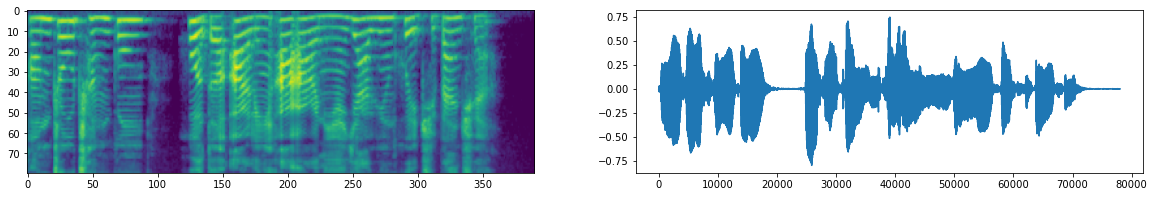

In [11]:
plot_and_play(load_mel(metadata[2]))

In [12]:
def gen_spacing(sec) : 
    return np.zeros((int((16000/200) * sec), 80), dtype=np.float32)

def mel_concate(mels) : 
    # mels : List[ndarray<T,mel>]
    res = [mels[0]]
    for mel in mels[1:] : 
        res.append(gen_spacing(0))
        res.append(mel)
    return np.concatenate(res, axis=0)
#     return res

In [13]:
m1 = load_mel(metadata[2])
m2 = load_mel(metadata[0])

In [14]:
mc = mel_concate([load_mel(ml) for ml in metadata[:4]])

In [15]:
mc.shape

(1067, 80)

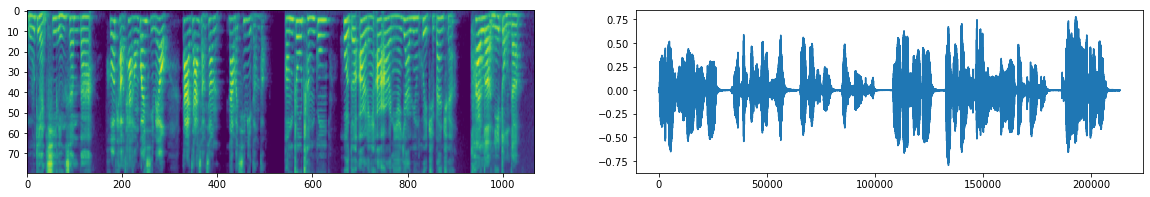

In [16]:
plot_and_play(mc)

## 2.2 draw samples based on speaker identity

In [17]:
mel_pattern = re.compile(r'mel-(?P<sid>[A-Z0-9]+)\.wav\.npy')

def spkid_from_melpath(melpath) : 
    return mel_pattern.match(os.path.basename(melpath)).group('sid')

def get_spkid(ml) : 
    return spkid_from_melpath(ml.mel)[:7]
def get_sentid(ml) : 
    return spkid_from_melpath(ml.mel)[7:]
    

In [18]:
from pinyin_toolkit import misc
metadata_by_spk = misc.index_data_by(metadata, get_spkid)  # Dict[spkid, List[metaline]]
spkids = list(metadata_by_spk.keys())

59688it [00:00, 307999.41it/s]


In [19]:
sum([len(xs) for k,xs in metadata_by_spk.items()])

60098

In [23]:
import random
random.seed(hparams.tacotron_random_seed)

def load_embedding(ml) : 
    return np.load(os.path.join('datasets', 'best_of_ssb_vad', 'embeds', ml.emb))

def draw_speaker() : 
    # returns list of metaline
    return metadata_by_spk[random.choice(spkids)]

def draw_sentences(sent_pool) : 
    if len(sent_pool) < 2 : 
        return None, 0
    
    # used to make a new version (v2) of longer senteces
    n_element = min(random.choices(
        [2, 3, 4],
        [0.6, 0.2, 0.2],
        k = 1
    )[0], len(sent_pool))
        
    """
    # used to make first edition of longer_senteces
    n_element = min(random.choices(
        [2, 3],
        [0.8, 0.2],
        k = 1
    )[0], len(sent_pool))
    
    """
    
    sents = random.sample(sent_pool, n_element)
    return sents, n_element

def produce_long_sentence() : 
    
    sents, n_elem = draw_sentences(draw_speaker())  # list of metaline
    if n_elem == 0 : 
        return None
    
    mels = [load_mel(ml) for ml in sents]
    long_mel = mel_concate(mels)
    
    
    return sents, long_mel
    
    

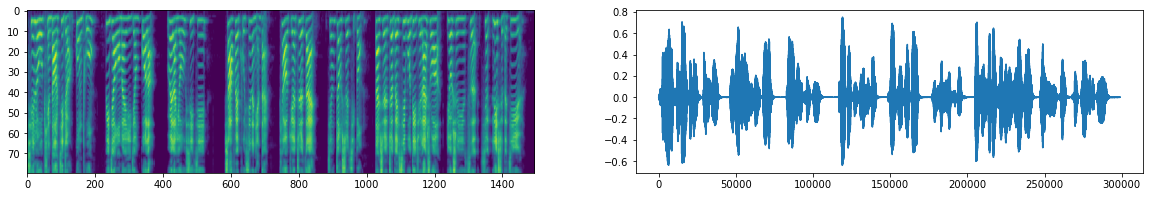

In [24]:
bag = produce_long_sentence()
if bag is not None : 
    ss, mel = bag
plot_and_play(mel)

In [28]:
def merge_metaline(idx, mls) : 
    audios = ','.join([ml.audio for ml in mls])
    new_sid = f'{get_spkid(mls[0])}{len(mls):1}{idx:03}'
    new_text = ' '.join([ml.txt for ml in mls])
    
    return metaline(
        audios,
        f'mel-{new_sid}.wav.npy',
        mls[0].emb,
        mls[0].wlen,
        mls[0].flen,
        new_text
    )

def instantiate_long_sentence(idx) : 
    data = produce_long_sentence()
    if data is not None : 
        sents, long_mel = data
        new_metaline = merge_metaline(idx, sents)
        np.save(os.path.join('datasets', 'best_of_ssb_vad', 'mels', new_metaline.mel), long_mel)
        return new_metaline
    else : 
        return None
    
def make_longer_sents(N = 30000) : 
    idx = 0
    new_metalines = []
    while idx < N : 
        if idx % 2000 == 0 : 
            print(f'idx = {idx}')
        r = instantiate_long_sentence(idx)
        if r is not None : 
            new_metalines.append(r)
            idx += 1
    return new_metalines

In [29]:
longer_metaline = make_longer_sents()

idx = 0
idx = 2000
idx = 2000
idx = 2000
idx = 4000
idx = 6000
idx = 8000
idx = 10000
idx = 12000
idx = 14000
idx = 16000
idx = 18000
idx = 20000
idx = 22000
idx = 24000
idx = 26000
idx = 28000


In [30]:
len(longer_metaline)

30000

In [34]:
longer_metaline[4]

metaline(audio='audio-SSB15550365.wav.npy,audio-SSB15550312.wav.npy,audio-SSB15550405.wav.npy,audio-SSB15550284.wav.npy', mel='mel-SSB15554004.wav.npy', emb='embed-SSB15550365.wav.npy', wlen='100477', flen='503', txt='D AA4 M AA1 % T IY4 AW4 % G UW2 AE2 NG2 CH AE2 NG2 % W UW3 JH IY4 % F AE2 NG2 J IY4 AA4 $ X IY4 AA4 D IY1 EH1 % SH IY2 AA4 R4 W AE4 N4 % F AE2 NG2 $ JH UW3 Y UW4 % K UW1 W UW2 L EY4 $ X IY1 N1 M IY2 N2 SH IY4 % S IY1 F AA3 J UW2 % Y AW2 B AW3 S IY1 % F AA2 S UW3 AO3 $ Y IY1 N1 W EY4 % D AA4 J IY1 AA1 % D OW1 SH IY4 % B UW4 K AE1 N1 Q IY2 Y OW2 $ X IY3 AE3 NG3 T IY1 NG1 % G ER1 Q UW3 % JH OW1 Y AE4 N4 HH UH2 NG2 D ER5 % G ER1 $')

In [36]:
with open(os.path.join('datasets/best_of_ssb_vad', 'longer_meta.v2.txt'), 'w') as f : 
    f.write('\n'.join([
        '|'.join(ml) for ml in longer_metaline
    ]))

In [43]:
! wc -l datasets/best_of_ssb_vad/blended_meta.v2.txt

90097 datasets/best_of_ssb_vad/blended_meta.v2.txt


In [39]:
blended_metaline = longer_metaline + metadata

In [40]:
len(blended_metaline)

90098

In [41]:
random.shuffle(blended_metaline)

In [42]:
with open(os.path.join('datasets/best_of_ssb_vad', 'blended_meta.v2.txt'), 'w') as f : 
    f.write('\n'.join([
        '|'.join(ml) for ml in blended_metaline
    ]))

In [26]:
! wc -l datasets/best_of_ssb_vad/train.txt

90097 datasets/best_of_ssb_vad/train.txt


In [27]:
! mv datasets/best_of_ssb_vad/blended_meta.txt datasets/best_of_ssb_vad/blended_meta.v1.txt